In [1]:
from collections import deque
from env.tsp_env import TspEnv
from utils import tsp_plots
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim

## Set parameters

In [2]:
NUMBER_OF_CITIES = 10

In [3]:
# Discount rate of future rewards
GAMMA = 0.99
# Learing rate for neural network
LEARNING_RATE = 0.001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 100000
# Frequency of neural net 
BATCH_SIZE = 5
# Number of game steps to play before starting training
REPLAY_START_SIZE = 10000
# Exploration rate (episolon) is probability of choosing a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.995
# Number of steps between target network update
SYNC_TARGET_STEPS = 1000

In [4]:
# Set stopping conditions
MAXIMUM_RUNS = 50000
MAXIMUM_TIME_MINS =  480
NO_IMPROVEMENT_RUNS = 5000
NO_IMPROVEMENT_TIME = 120

In [5]:
# Set whether to plot all new best routes as they are found
PLOT_NEW_BEST_ROUTES = True

In [6]:
class DuellingDQN(nn.Module):

    """
    Deep Q Network solver. Includes control variables, memory of 
    state/action/reward/end, neural net,and methods to act, 
    remember, and update neural net by sampling from memory.
    """
    
    def __init__(self, observation_space, action_space, learning_rate,
                 exploration_max):
        """Constructor method. Set up neural nets."""

        # Set starting exploration rate
        self.exploration_rate = exploration_max
        
        # Set up action space (choice of possible actions)
        self.action_space = action_space
              
        super(DuellingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(observation_space, observation_space * 4),
            nn.ReLU(),
            nn.Linear(observation_space * 4, observation_space * 4),
            nn.ReLU()
            )
        
        self.advantage = nn.Sequential(
            nn.Linear(observation_space * 4, observation_space * 4),
            nn.ReLU(),
            nn.Linear(observation_space * 4, action_space)
        )
        
        self.value = nn.Sequential(
            nn.Linear(observation_space * 4, observation_space * 4),
            nn.ReLU(),
            nn.Linear(observation_space * 4, 1)
        )
        
        # Set optimizer
        self.optimizer = optim.Adam(
                params=self.parameters(), lr=learning_rate)
        

    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
            
        else:
            # Otherwise get predicted Q values of actions
            q_values = self.forward(torch.FloatTensor(state))
            # Get index of action with best Q
            action = np.argmax(q_values.detach().numpy()[0])
        
        return  action
        
  
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        action_q = value + advantage  - advantage.mean()
        return action_q

In [7]:
class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self, memory_size):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=memory_size)

    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [8]:
def optimize_duelling_dqn(policy_net, target_net, memory, batch_size, 
                          exploration_decay, exploration_min, gamma):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < batch_size:
        return    
 
    # Reduce exploration rate
    policy_net.exploration_rate *= exploration_decay
    policy_net.exploration_rate = max(exploration_min, 
                                      policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = random.sample(memory, batch_size)
    for state, action, reward, state_next, terminal in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
       
        if not terminal:
            # For non-terminal actions get Q from policy net
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get next state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get targen net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent target net gradients being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (gamma * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward

        # Update neural net
        
        # Reset net gradients
        policy_net.optimizer.zero_grad()  
        # calculate loss
        loss_v = nn.MSELoss()(state_action_values, expected_state_action_values)
        # Backpropogate loss
        loss_v.backward()
        # Update network gradients
        policy_net.optimizer.step()  

    return

In [9]:
def main():
    """Main program loop"""
    
    # Set up environment
    time_start = time.time()
    env = TspEnv(number_of_cities = NUMBER_OF_CITIES)
    
    # Get number of observations returned for state
    observation_space = env.observation_space.shape[0] * 2
    
    # Get number of actions possible
    n_actions = len(env.action_space)
    
    # Set up policy and target neural nets
    policy_net = DuellingDQN(observation_space, n_actions, LEARNING_RATE, 
                             EXPLORATION_MAX)
    target_net = DuellingDQN(observation_space, n_actions, LEARNING_RATE,
                             EXPLORATION_MAX)

    
    # Copy weights from policy_net to target
    target_net.load_state_dict(policy_net.state_dict())
    
    # Set target net to eval rather than training mode
    # We do not train target net - ot is copied from policy net at intervals
    target_net.eval()    
    
    # Set up memory
    memory = Memory(MEMORY_SIZE)    
    
    # Set up list for results
    results_run = []
    results_exploration = []
    total_rewards = []
    best_reward = 0
    best_route = None
    
    # Set run and time of last best route
    run_last_best = 0
    time_last_best = time.time()

    # Set up run counter and learning loop
    step = 0
    run = 0
    continue_learning = True
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        # Increment run (episode) counter and reset route & run reward
        run += 1; route = []; total_reward = 0
        
        # Start run and get first state observations
        state, reward, terminal, info = env.reset()
        total_reward += reward
        
        # Reshape state into 2D array with state observations as first 'row'
        state = np.reshape(state, [1, observation_space])        

        # Continue loop until episode complete
        while True:
            
            # Increment step counter
            step += 1
            
            # Get action to take
            action = policy_net.act(state)
            route.append(action)
            
            # Act
            state_next, reward, terminal, info = env.step(action)
            total_reward += reward
                     
            # Get observations for new state (s')
            state_next = np.reshape(state_next, [1, observation_space])
                        
            # Record state, action, reward, new state & terminal
            memory.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            # Update neural net (if enough steps in memory)
            
            if len(memory.memory) >= REPLAY_START_SIZE:
                # Update policy net 
                optimize_duelling_dqn(policy_net, target_net, memory.memory,
                                      BATCH_SIZE, EXPLORATION_DECAY, 
                                      EXPLORATION_MIN, GAMMA)
                
                # Update the target network at intervals
                if step % SYNC_TARGET_STEPS == 0:
                    target_net.load_state_dict(policy_net.state_dict())        
                 
            # Actions to take if end of game episode
            if terminal:
                # Clear print row content
                clear_row = '\r' + ' '*100 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run: 5.0f}, ', end='')
                exp = policy_net.exploration_rate
                print (f'exploration: {exp: 4.3f}, ', end='')
                print (f'total reward: {total_reward: 6.0f}', end='')
                
                # Add run info to lists
                results_run.append(run)
                results_exploration.append(policy_net.exploration_rate)
                total_rewards.append(total_reward)

                # Check for best route so far
                if total_reward > best_reward:
                    best_reward = total_reward
                    best_route = route
                    run_last_best = run
                    time_last_best = time.time()
                    time_elapsed = (time.time() - time_start) / 60
                    print(f'\nNew best run. Run : {run: 5.0f},  ' \
                          f'Time {time_elapsed: 4.0f}  ' \
                          f'Reward {total_reward: 6.1f}')

                    # Plot new best route
                    if PLOT_NEW_BEST_ROUTES:
                        tsp_plots.plot_route(env, best_route)
                        print()
                    
                # Check stopping conditions
                stop = False
                if step > REPLAY_START_SIZE:
                    if run > MAXIMUM_RUNS:
                        stop = True
                    elif time.time() - time_start > MAXIMUM_TIME_MINS * 60:
                        stop = True
                    elif time.time() - time_last_best > NO_IMPROVEMENT_TIME*60:
                        stop = True
                    elif run - run_last_best > NO_IMPROVEMENT_RUNS:
                        stop = True
                        
                if stop:
                    # End training
                    continue_learning = False
     
                # End episode
                break
            
    ############################# Plot results #################################
        
    # Plot result progress
    tsp_plots.plot_result_progress(total_rewards)
    
    # Plot best route (if acceptable route found)
    if best_reward > 0:
        tsp_plots.plot_route(env, best_route)
        
    ###################### Show route and distances ############################
    
    print ('Route')
    print (best_route)
    print ()
    print ('Best route distance')
    print (f'{env.state.calculate_distance(best_route):.0f}')

Run:    10, exploration:  1.000, total reward:    397                                               
New best run. Run :    10,  Time    0  Reward  396.8


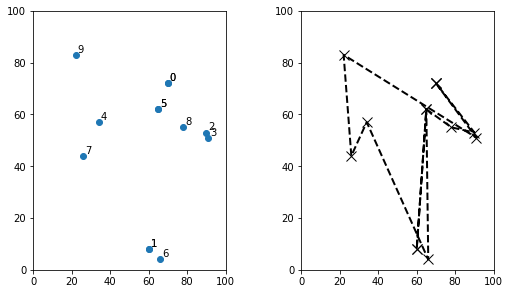


Run:    57, exploration:  1.000, total reward:    397                                               
New best run. Run :    57,  Time    0  Reward  397.2


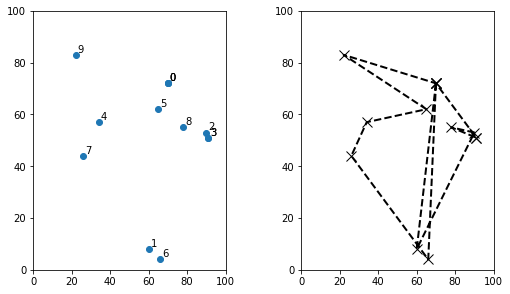


Run:   283, exploration:  0.010, total reward:    647                                               
New best run. Run :   283,  Time    5  Reward  646.6


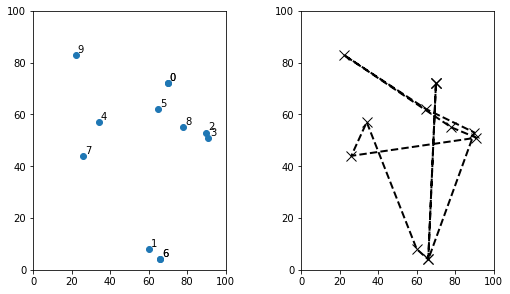


Run:   296, exploration:  0.010, total reward:    684                                               
New best run. Run :   296,  Time    6  Reward  684.4


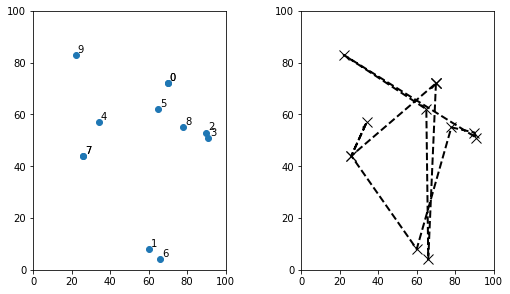


Run:   436, exploration:  0.010, total reward:    836                                               
New best run. Run :   436,  Time    8  Reward  836.2


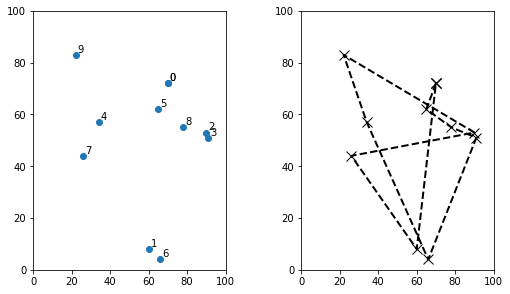


Run:   524, exploration:  0.010, total reward:    845                                               
New best run. Run :   524,  Time    8  Reward  844.5


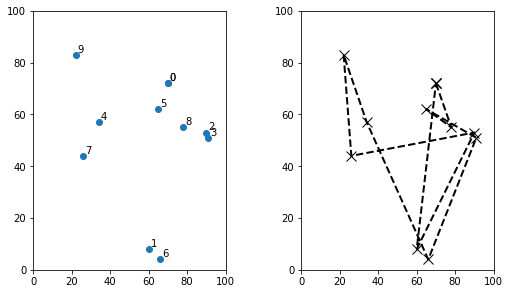


Run:   531, exploration:  0.010, total reward:    867                                               
New best run. Run :   531,  Time    9  Reward  866.8


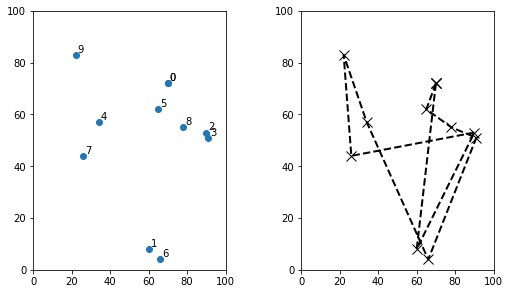


Run:   595, exploration:  0.010, total reward:    883                                               
New best run. Run :   595,  Time    9  Reward  882.9


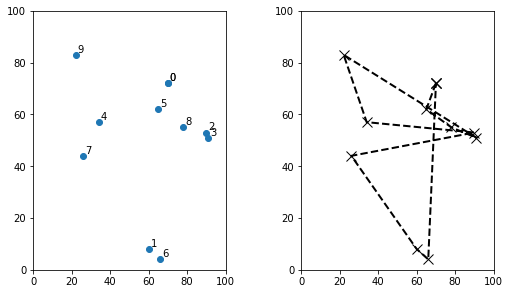


Run:   596, exploration:  0.010, total reward:    895                                               
New best run. Run :   596,  Time    9  Reward  895.2


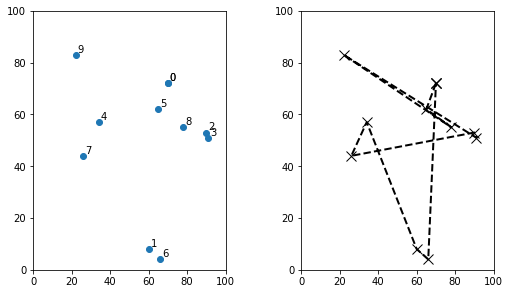


Run:   637, exploration:  0.010, total reward:    899                                               
New best run. Run :   637,  Time    9  Reward  899.3


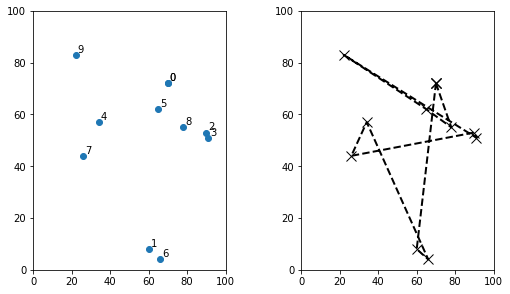


Run:   702, exploration:  0.010, total reward:    922                                               
New best run. Run :   702,  Time    9  Reward  921.5


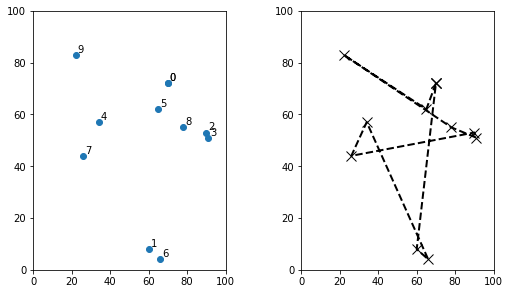


Run:   931, exploration:  0.010, total reward:    965                                               
New best run. Run :   931,  Time   10  Reward  964.6


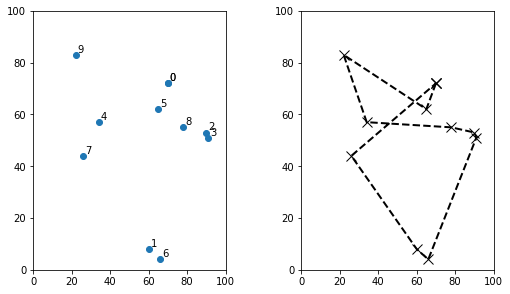


Run:  1253, exploration:  0.010, total reward:    967                                               
New best run. Run :  1253,  Time   11  Reward  966.6


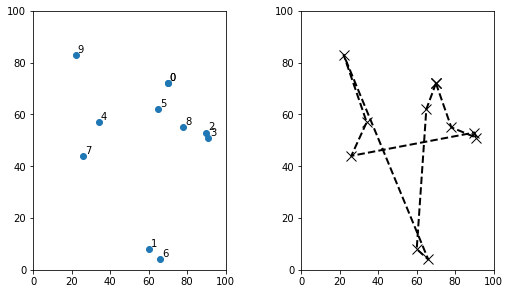


Run:  1276, exploration:  0.010, total reward:    971                                               
New best run. Run :  1276,  Time   11  Reward  971.2


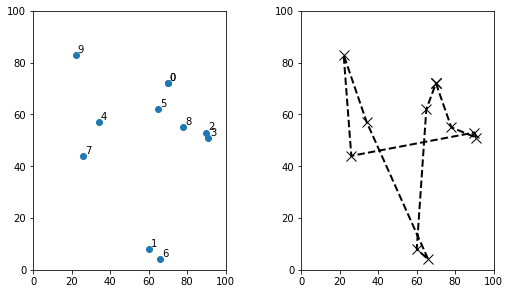


Run:  1453, exploration:  0.010, total reward:    978                                               
New best run. Run :  1453,  Time   11  Reward  978.4


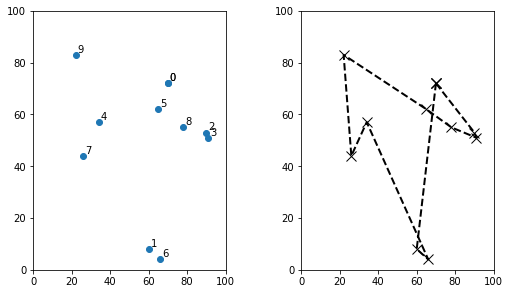


Run:  1455, exploration:  0.010, total reward:    994                                               
New best run. Run :  1455,  Time   11  Reward  994.3


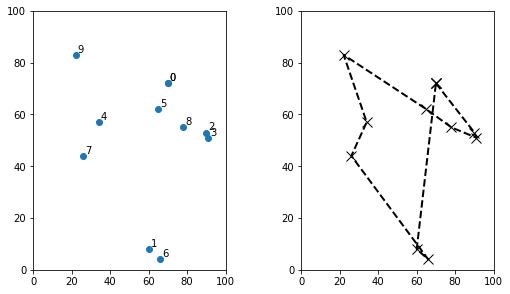


Run:  2824, exploration:  0.010, total reward:    997                                               total reward:    845
New best run. Run :  2824,  Time   15  Reward  997.3


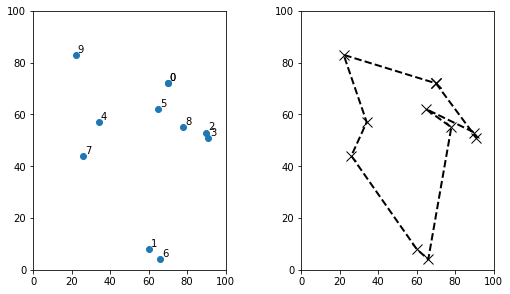


Run:  3148, exploration:  0.010, total reward:   1027                                               
New best run. Run :  3148,  Time   16  Reward  1026.6


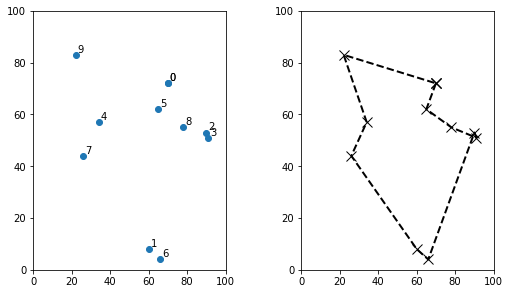


Run:  4386, exploration:  0.010, total reward:   1029                                               
New best run. Run :  4386,  Time   19  Reward  1029.3


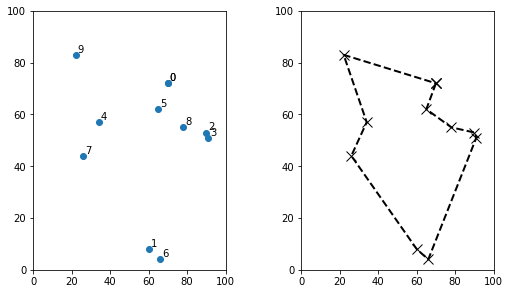


Run:  9387, exploration:  0.010, total reward:   1020                                               total reward:    992

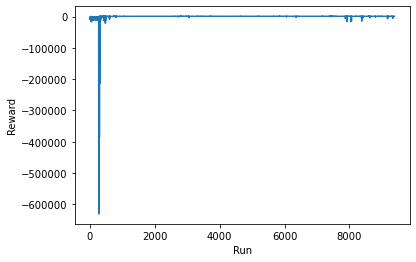

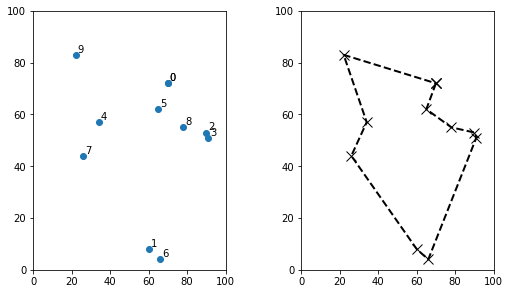

Route
[5, 8, 2, 3, 6, 1, 7, 4, 9, 0]

Best route distance
232


In [10]:
main()